In [1]:
## Set auto-reload
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np

from utils import get_bigquery_result

%matplotlib inline

In [3]:
""" Load the data """
query_template = open("sql/eda_query.sql", "r").read()
params = {
    "start_time": "2021-10-27 00:00:00",
    "end_time": "2021-10-30 00:00:00"
}
sql = query_template.format(**params)
filepath = "input/eda_data.csv"

df = get_bigquery_result(sql, filepath=filepath, gcp_project="ox-datascience-devint")
display(df.head())

Loaded from cached file..


,auction_hour,bidderTimeout,win,pubrev
0,21,1500,1,22078989
1,21,1500,0,0
2,21,1500,0,0
3,21,1500,0,0
4,21,1500,1,20408975


# EDA

In [4]:
""" Get win-rate and average pubrev """
avgs = df.groupby(["bidderTimeout", "auction_hour"]).mean()

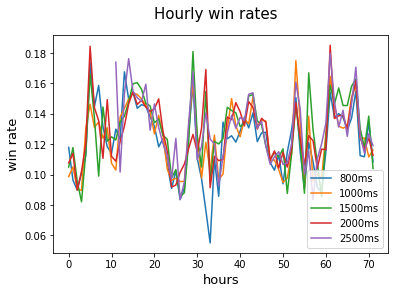

In [5]:
""" Plot hourly win-rates """
fig, ax = plt.subplots()
timeouts = [800, 1000, 1500, 2000, 2500]

for timeout in timeouts:
    sub_df = avgs.xs(timeout, level="bidderTimeout")
    
    hours = sub_df.index
    win_rates = sub_df["win"]
    ax.plot(hours, win_rates, label=f"{timeout}ms")


ax.legend()
ax.set_xlabel("hours", fontsize=13)
ax.set_ylabel("win rate", fontsize=13)
fig.suptitle("Hourly win rates", fontsize=15)

if not os.path.exists("output/"):
    os.mkdir("output")
fig.savefig(f"output/eda_hourly_win_rate.png", dpi=150)

## Publisher revenue

In [6]:
wins = df[df["win"] == 1]

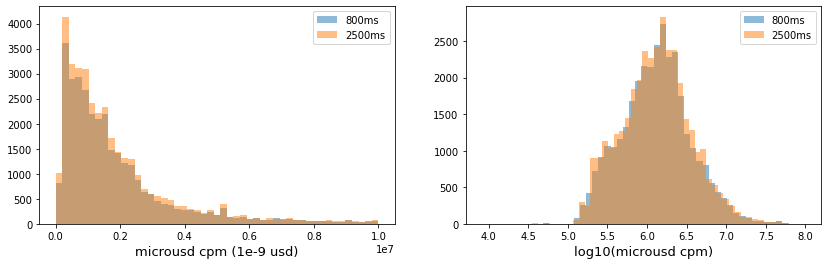

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(14, 4))
for timeout in [800, 2500]:
    sub_df = wins[wins["bidderTimeout"] == timeout]
    
    ax[0].hist(sub_df["pubrev"], bins=np.linspace(0, 1e7, 50), alpha=0.5, label=f"{timeout}ms")
    ax[1].hist(np.log10(sub_df["pubrev"] + 1), bins=50, alpha=0.5, label=f"{timeout}ms")
    
ax[0].legend(), ax[1].legend()
ax[0].set_xlabel("microusd cpm (1e-9 usd)", fontsize=13)
ax[1].set_xlabel("log10(microusd cpm)", fontsize=13)

if not os.path.exists("output/"):
    os.mkdir("output")
fig.savefig(f"output/eda_cpm_histogram.png", dpi=150)